In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl
import math
import os

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

from coefficient import * 

os.environ["PATH"]='/home/ngrewal/flask/flask/bin:'+os.environ["PATH"]

# Import the NaMaster python wrapper
import pymaster as nmt

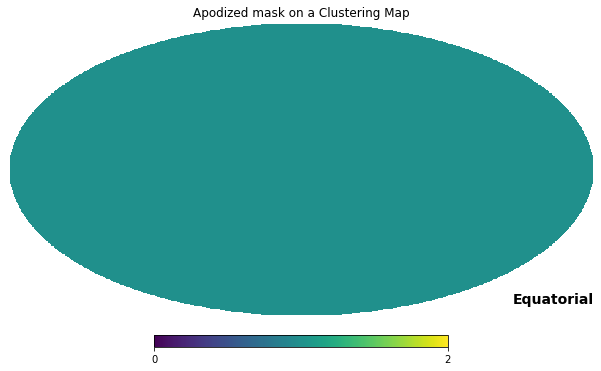

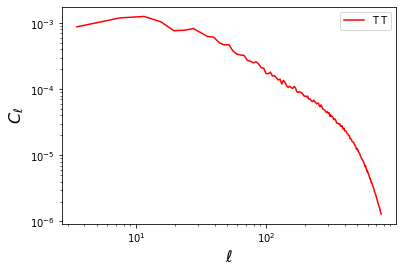

In [2]:
#  Simple example showcasing the use of NaMaster to compute the pseudo-Cl
#  estimator of the angular cross-power spectrum of a spin-0 field

# HEALPix resolution parameter used here
nside = 256
smoothing = 20 #arcmin

# Build clustering map
c_map = simulate_des_maps(0.3, 0.8, smoothing, nside,nmax=1)[0][0]

# Read mask and apodize it on a scale of ~1deg
#mask = nmt.mask_apodization(hp.read_map("mask.fits", verbose=False),1., apotype="Smooth")
#mask = nmt.mask_apodization(c_map,aposize=40) #this changes with mask
mask = np.ones(len(c_map))

hp.mollview(mask, coord=['G', 'C'], title='Apodized mask on a Clustering Map')
plt.show()

# Read healpix maps and initialize a spin-0
f_0 = nmt.NmtField(mask, [c_map])

# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 4)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0], 'r-', label='T T')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [4]:
def C_l(smoothing, nside, aposize, is_clustering):
    
    if is_clustering == True:
        map_ = simulate_des_maps(0.3, 0.8, smoothing, nside,nmax=1)[0][0]
    else:
        map_ = simulate_des_maps(0.3, 0.8, smoothing, nside,nmax=1)[1][0]
        
    mask = np.ones(len(c_map))                    # build mask
    f_0 = nmt.NmtField(mask, [map_])              # initialize spin-0
    b = nmt.NmtBin.from_nside_linear(nside, 4)    # apply binning with 4 ells per bandpower
    cl_00 = nmt.compute_full_master(f_0, f_0, b)  # computer MASTER estimator
    
    return cl_00

Cl_c = C_l(20,256,40,True)
Cl_l = C_l(20,256,40,False)

In [5]:
print('Clustering C_l:',len(Cl_c[0]),', Lensing C_l:',len(Cl_l[0]))

Clustering C_l: 191 , Lensing C_l: 191


In [6]:
## Simulation Variables
thr_ct = 10                                   # threshold count
nside = 256                                   # number of pixels on each side of the map
smoothing=20                                  # map scale
N = 12*nside*nside                            # total number of pixels
aposize = 1                                   # size of masks (in degrees)
b = nmt.NmtBin.from_nside_linear(nside, 4)    # apply binning with 4 ells per bandpower

## Analysis Variables
itr = 2#000                                    # number of iterations
map_len = 9                                   # sum of the number of lensing and clustering redshift bins
array_len = map_len*thr_ct*3                  # length of covariance array - multiply by 3 for 3 MFs
Cl_len = map_len*b.get_n_bands()              # length of Cls 

In [116]:
# calculate C_l for any map with masking applied

def C_l(map_,smoothing, nside, aposize):
        
    mask = np.ones(len(c_map))                    # build mask
    f_0 = nmt.NmtField(mask, [map_])              # initialize spin-0
    cl_00 = nmt.compute_full_master(f_0, f_0, b)  # computer MASTER estimator
    
    return cl_00[0]

In [117]:
# calculate and concatenate C_l for clustering and lensing maps

def C_l_2maps(c_map,l_map,smoothing, nside, aposize):
    
    Cl = np.zeros((len(c_map)+len(l_map),191)) # how to avoid hardcoding length of C_l?
    for i in range(len(c_map)):
        Cl[i] = C_l(c_map[i],smoothing,nside,aposize)  # clustering map
    for j in range(len(l_map)):
        Cl[i+j] = C_l(l_map[j],smoothing,nside,aposize)  # lensing map
    return Cl

In [118]:
# Calculate MFs and C_ls for clustering and lensing maps

v_all_fixed = np.zeros((itr,array_len+Cl_len)) 
for i in range(itr):
    # simulate maps
    clustering_maps, lensing_maps = simulate_des_maps(0.3, 0.8, smoothing, nside)
    # calc MFs
    v_fixed, v0_fixed, v1_fixed, v2_fixed = calc_mf_2maps(clustering_maps,lensing_maps,thr_ct,N)
    # calc C_ls
    CL = C_l_2maps(clustering_maps,lensing_maps,smoothing, nside, aposize)
    # combine into one array
    v_all_fixed[i] = np.concatenate((v0_fixed.flatten(),v1_fixed.flatten(),v2_fixed.flatten(),CL.flatten()))
    print(i)

v_all_fixed.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(50, 1989)

(1989, 1989)


<ipython-input-119-9086131bc98a>:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(cov)),origin='lower')


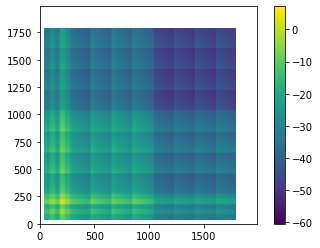

In [119]:
# covariance - make it bigger
cov = np.cov((v_all_fixed.transpose()))
print(cov.shape)
plt.imshow(np.log(abs(cov)),origin='lower')
plt.colorbar();

In [ ]:
# run without log
# try w just Cls

#fix mask